In [255]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [256]:
import math
import time

import numpy as np
import scipy.sparse as sp
from scipy.linalg import norm, svd, qr
from scipy.stats import ortho_group
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler

In [257]:
def diffsnorm(data, reconstruct):
    return norm(data-reconstruct)/norm(data+reconstruct)


In [258]:
def eig_error(eig_approx, eig):
    corr = np.linalg.norm(eig_approx-eig)
    corr = np.inner(eig_approx, eig)
    return corr


In [259]:
def subspace_error(U_approx, U):
    n_components = U.shape[1]
    A = U_approx.T.dot(U)
    B = U_approx.dot(U_approx.T)

    err = np.sqrt(n_components+np.trace(B.dot(B)) - 2 * np.trace(A.dot(A.T)))

    frob = np.linalg.norm(U-U_approx, ord='fro')

    return err/np.sqrt(n_components )


In [260]:
def modify_loading(loading, component):
    n_sample, n_component = loading.shape

    minimum = np.amin(loading, axis=0)
    maximum = np.amax(loading, axis=0)

    idx = []

    for i in range(n_sample):
        check = np.where((loading[i, :] == minimum) | (loading[i, :] == maximum), True, False)
        if True in check:
            idx.append(i)

    src_loading = loading[np.array(idx)]
    src_data = src_loading @ component

    return src_data


In [261]:
def process_partition(data, n_components):
    """
    Split data into four partitions and apply PCA on each partition
    """
    partition = []
    
    for i in range(2):
        for j in range(2):
            part = data[i*16:i*16+16, j*16:j*16+16, :, :]
            part_reshape = part.reshape((part.shape[0]*part.shape[1], part.shape[2]*part.shape[3]))
            U, S, V = svd(part_reshape, full_matrices=False)            
            partition.append((U[:, :n_components], S[:n_components], V[:n_components], part_reshape[0]))
    
    return partition


In [262]:
def merge(data, partition, n_components):
    """
    Merge PCA results from partitions
    """
    ipca = IncrementalPCA(n_components=n_components)
    
    for part in partition:
        reconstruct = modify_loading(part[0]*part[1], part[2])
        ipca.partial_fit(reconstruct)
    
    data = data.reshape((1024, 1024))
    data_transformed = ipca.fit_transform(data)
    reconstructed_data = ipca.inverse_transform(data_transformed)
    
    return data_transformed, reconstructed_data
        
        

In [263]:
def run_pca(data, n_components=100):
        
    sig_dim = int(math.sqrt(data.shape[0]))
    nav_dim = int(math.sqrt(data.shape[1]))
    
    assert (sig_dim ** 2) == data.shape[0]
    assert (nav_dim ** 2) == data.shape[1]
    
    # reformat data into sig and nav dimension
    data = data.reshape((sig_dim, sig_dim, nav_dim, nav_dim))

    partition = process_partition(data, n_components)
    data_transformed, reconstructed_data = merge(data, partition, n_components)
        
    orig_data = data.reshape((sig_dim**2, nav_dim**2))
    norm_diff = diffsnorm(reconstructed_data, orig_data)
    print("norm difference between original and reconstructed data: ", norm_diff)
            
    return data_transformed, norm_diff

# data prep

In [264]:
component = ortho_group.rvs(dim=1024)[:100, :]

In [265]:
# standard data generated by 100 components
loading = np.random.rand(1024, 100)
data = loading @ component

# random noisy data
noise_data = np.random.rand(1024, 1024)

# A component contained within a single frame
last_component, new_component = component[99], component[:99]
loading = np.random.rand(1024, 99)
single_data = loading @ new_component

# Scale components differently to check if PCA catches them
scaler = np.arange(0.01, 11, 0.01)[:1024].T
scaler = scaler.reshape((-1, 1)).T
scaler = np.repeat(scaler, repeats=100, axis=0)
new_component = np.multiply(scaler, component)

loading = np.random.rand(1024, 100)

scaled_data = loading @ new_component

# Data generated using 100 components vs Noisy data (w/ dimension 1024)

In [266]:
for n_component in range(10, 200, 10):
    U, S, V = svd(data, full_matrices=False)
    U, S, V = U[:, :n_component], S[:n_component], V[:n_component]
    reconstructed_data = ((data @ V.T) @ V)
    norm_diff = diffsnorm(reconstructed_data, data)
    print(f"norm difference wih {n_component} components using full batch data: {norm_diff}")

norm difference wih 10 components using full batch data: 0.25043813483128186
norm difference wih 20 components using full batch data: 0.225408674336417
norm difference wih 30 components using full batch data: 0.20182937823600505
norm difference wih 40 components using full batch data: 0.17922213642078205
norm difference wih 50 components using full batch data: 0.15701723218927677
norm difference wih 60 components using full batch data: 0.13479319483541607
norm difference wih 70 components using full batch data: 0.1119035248584139
norm difference wih 80 components using full batch data: 0.0874429935524137
norm difference wih 90 components using full batch data: 0.05869254145353549
norm difference wih 100 components using full batch data: 6.261895807859706e-16
norm difference wih 110 components using full batch data: 6.130099723451932e-16
norm difference wih 120 components using full batch data: 6.144327679075642e-16
norm difference wih 130 components using full batch data: 6.16139008930

In [267]:
for n_component in range(10, 200, 10):
    U, S, V = svd(noise_data, full_matrices=False)
    U, S, V = U[:, :n_component], S[:n_component], V[:n_component]
    reconstructed_data = (noise_data @ V.T) @ V
    norm_diff = diffsnorm(reconstructed_data, noise_data)
    print(f"norm difference wih {n_component} components using full batch data: {norm_diff}")

norm difference wih 10 components using full batch data: 0.27122387996466063
norm difference wih 20 components using full batch data: 0.26515461536984053
norm difference wih 30 components using full batch data: 0.25935102599839915
norm difference wih 40 components using full batch data: 0.25375176067507643
norm difference wih 50 components using full batch data: 0.24831779688149958
norm difference wih 60 components using full batch data: 0.24303106314412018
norm difference wih 70 components using full batch data: 0.23788410579789798
norm difference wih 80 components using full batch data: 0.23287435747901625
norm difference wih 90 components using full batch data: 0.2279905000657593
norm difference wih 100 components using full batch data: 0.22320691805716125
norm difference wih 110 components using full batch data: 0.2185311543673824
norm difference wih 120 components using full batch data: 0.21395286376225828
norm difference wih 130 components using full batch data: 0.209467446775008

In [268]:
data_transformed, norm_diff = run_pca(data)

norm difference between original and reconstructed data:  6.214346901222358e-16


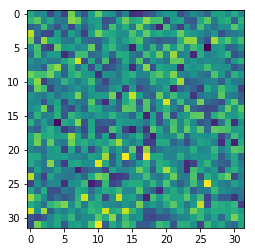

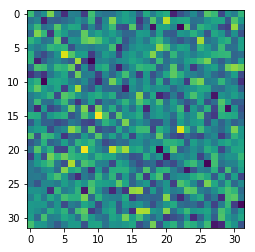

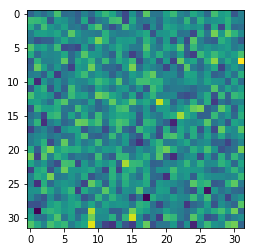

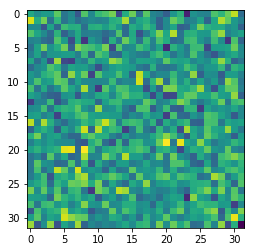

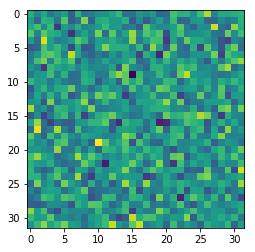

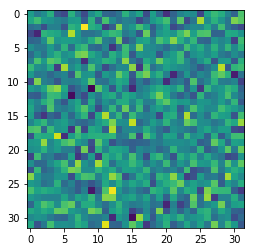

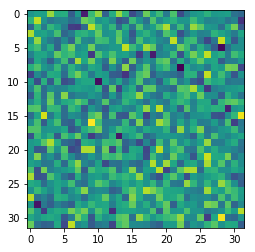

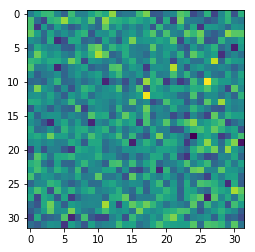

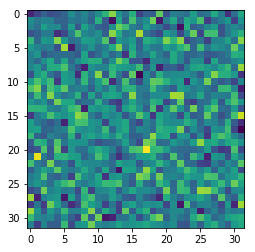

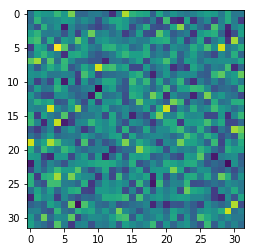

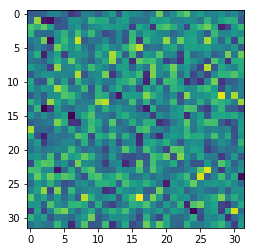

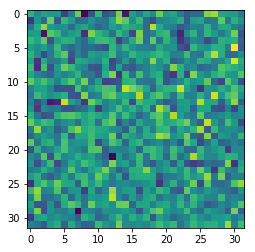

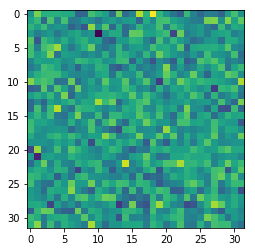

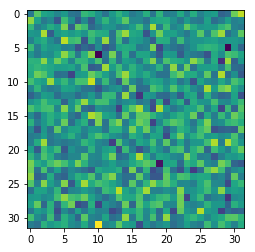

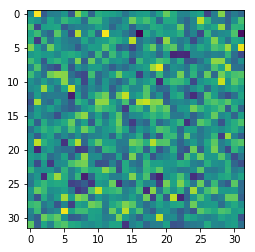

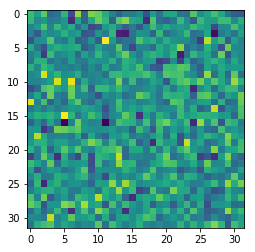

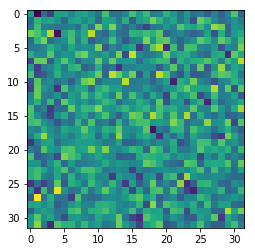

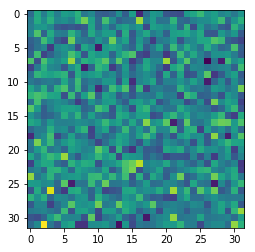

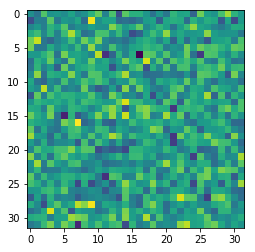

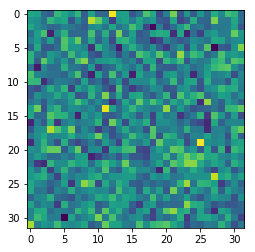

In [269]:
# visualize first 20 components
for i in range(20):
    component = data_transformed[:, i]
    vis = component.reshape((32, 32))

    f, axes = plt.subplots()
    axes.imshow(vis)

In [270]:
data_transformed, norm_diff = run_pca(noise_data)

norm difference between original and reconstructed data:  0.22286705173694243


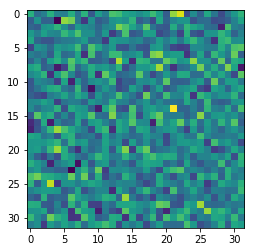

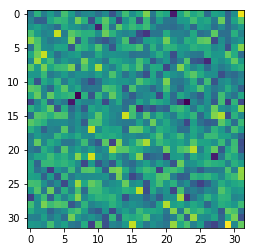

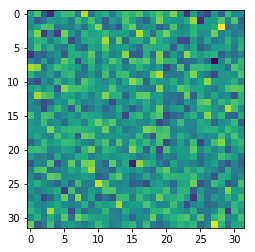

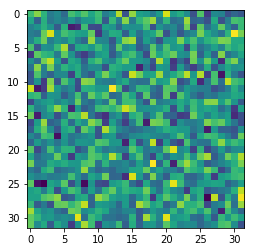

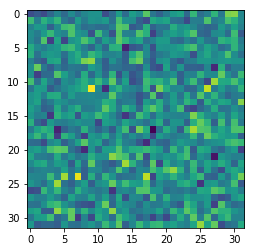

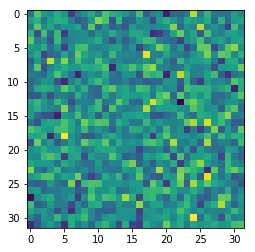

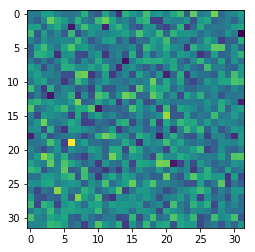

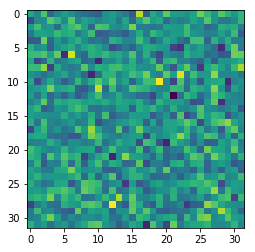

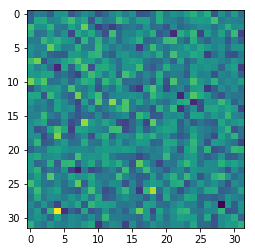

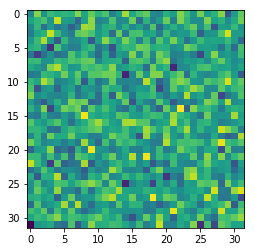

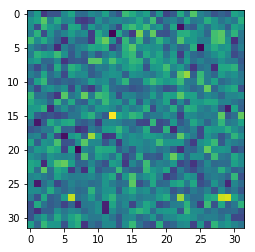

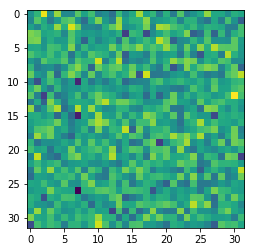

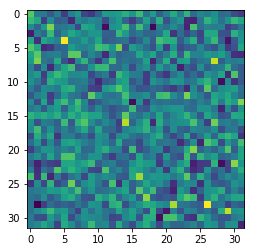

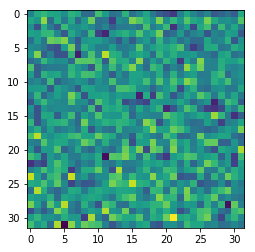

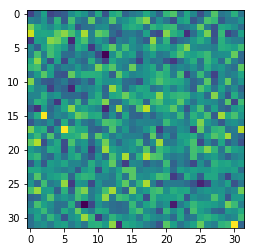

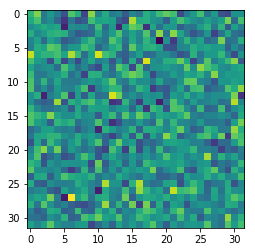

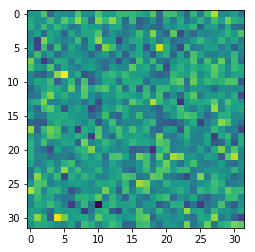

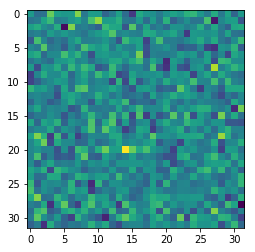

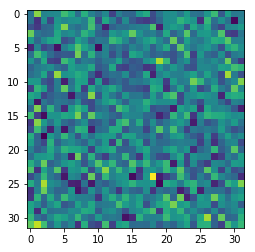

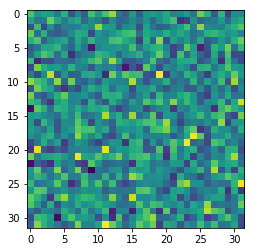

In [271]:
# visualize first 20 components
for i in range(20):
    component = data_transformed[:, i]
    vis = component.reshape((32, 32))

    f, axes = plt.subplots()
    axes.imshow(vis)


# A component contained only within a single frame

In [272]:
for factor in np.arange(0.05, 1, 0.2):
    new_single = single_data.copy()
    new_single[0, :] += last_component * factor
    print("99 components")
    data_transformed, norm_diff = run_pca(new_single, n_components=99)
    print("100 components")
    data_transformed, norm_diff = run_pca(new_single, n_components=100)

99 components
norm difference between original and reconstructed data:  0.0001286711640629478
100 components
norm difference between original and reconstructed data:  5.985943772226192e-16
99 components
norm difference between original and reconstructed data:  0.0006433278561297708
100 components
norm difference between original and reconstructed data:  5.854478886911462e-16
99 components
norm difference between original and reconstructed data:  0.0011578723982069398
100 components
norm difference between original and reconstructed data:  5.736074541379424e-16
99 components
norm difference between original and reconstructed data:  0.0016722138910645193
100 components
norm difference between original and reconstructed data:  5.849462462422924e-16
99 components
norm difference between original and reconstructed data:  0.002186259388744269
100 components
norm difference between original and reconstructed data:  6.0418627360098e-16


In [273]:
data_transformed, norm_diff = run_pca(single_data, n_components=100)

norm difference between original and reconstructed data:  5.021440050367776e-16


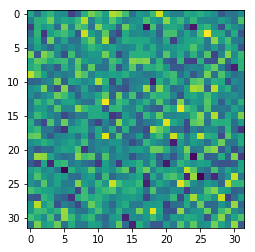

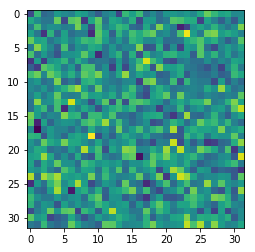

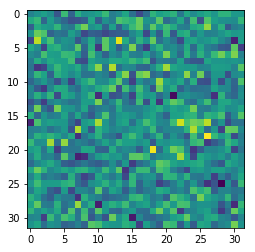

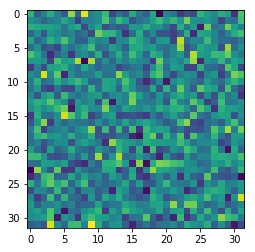

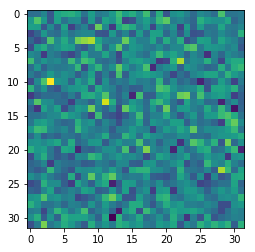

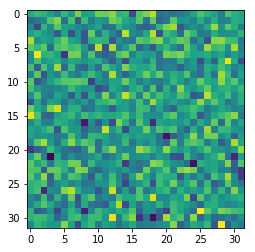

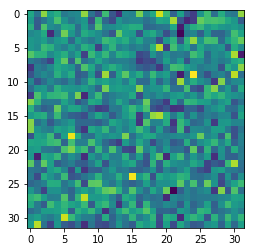

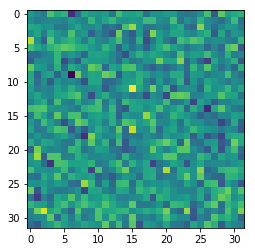

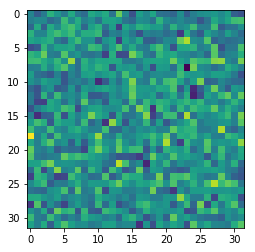

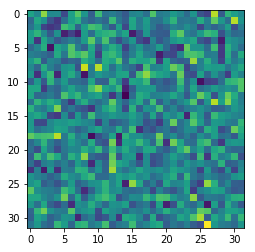

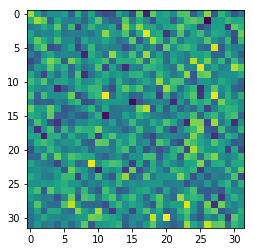

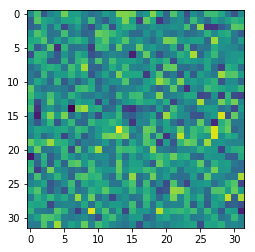

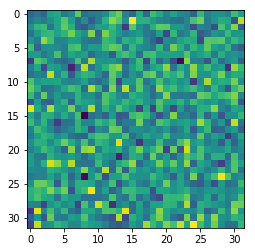

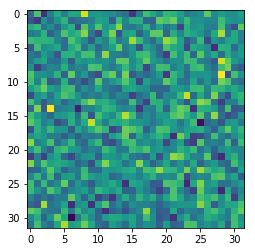

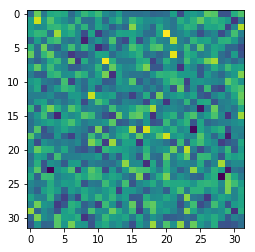

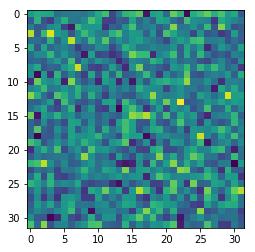

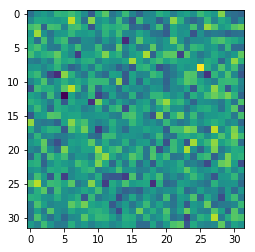

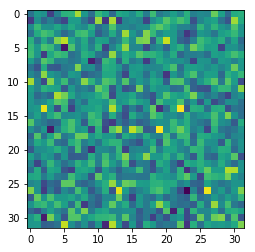

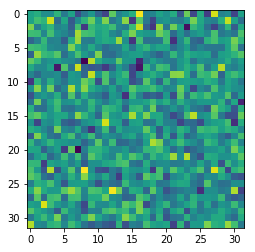

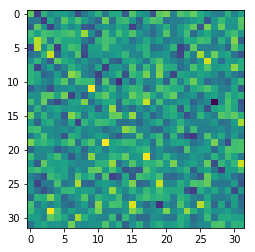

In [274]:
# visualize first 20 components
for i in range(20):
    component = data_transformed[:, i]
    vis = component.reshape((32, 32))

    f, axes = plt.subplots()
    axes.imshow(vis)


In [275]:
for n_component in range(90, 110, 1):
    new_single = single_data.copy()
    new_single[0, :] += last_component * factor
    U, S, V = svd(new_single, full_matrices=False)
    U, S, V = U[:, :n_component], S[:n_component], V[:n_component]
    reconstructed_data = ((new_single @ V.T) @ V)
    norm_diff = diffsnorm(reconstructed_data, new_single)
    print(f"norm difference wih {n_component} components using full batch data: {norm_diff}")

norm difference wih 90 components using full batch data: 0.05596137884481879
norm difference wih 91 components using full batch data: 0.05246848851795176
norm difference wih 92 components using full batch data: 0.048778748658768384
norm difference wih 93 components using full batch data: 0.04482771720979486
norm difference wih 94 components using full batch data: 0.040651899623470156
norm difference wih 95 components using full batch data: 0.03610544346879802
norm difference wih 96 components using full batch data: 0.031028667493509847
norm difference wih 97 components using full batch data: 0.02503651600206809
norm difference wih 98 components using full batch data: 0.017509777191013928
norm difference wih 99 components using full batch data: 0.0021887102289523436
norm difference wih 100 components using full batch data: 5.705248110142981e-16
norm difference wih 101 components using full batch data: 5.658243572677298e-16
norm difference wih 102 components using full batch data: 5.6636

# Differing intensities of component vectors

In [276]:
scaler = np.arange(0.01, 11, 0.01)[:1024].T
scaler = scaler.reshape((-1, 1)).T
scaler = np.repeat(scaler, repeats=100, axis=0)
new_component = np.multiply(scaler, component)

loading = np.random.rand(1024, 100)

scaled_data = loading @ new_component

In [277]:
# compare 99 components with 100 components results
data_transformed, norm_diff = run_pca(scaled_data, 99)
data_transformed, norm_diff = run_pca(scaled_data, 100)
data_transformed, norm_diff = run_pca(scaled_data, 101)

norm difference between original and reconstructed data:  8.977487052806174e-17
norm difference between original and reconstructed data:  8.943999193134441e-17
norm difference between original and reconstructed data:  8.913339652371317e-17


# Add Gausian noise to the data

In [278]:
def find_noise_threshold(data):
    norm_diff = 1
    factor = 0.01
    
    while norm_diff > 1e-3:
        noise = np.random.normal(0, 0.1, size=(1024, 1024)) * factor
        new_data = data.copy()
        new_data += noise
        data_transformed, norm_diff = run_pca(new_data, 100)
        
        if norm_diff <= 1e-3:
            print(f"Using {factor} for factor of a normal distribution as an upper bound, the PCA works well")
            return
        
        factor /= 5

In [279]:
# single component contained in a single frame
find_noise_threshold(single_data)

norm difference between original and reconstructed data:  0.002511540148640329
norm difference between original and reconstructed data:  0.0005026246485341607
Using 0.002 for factor of a normal distribution as an upper bound, the PCA works well


In [280]:
# scale the components to check the intensity
find_noise_threshold(scaled_data)

norm difference between original and reconstructed data:  4.3593479615930626e-06
Using 0.01 for factor of a normal distribution as an upper bound, the PCA works well


In [281]:
# orthonormal dataset
find_noise_threshold(data)

norm difference between original and reconstructed data:  0.0024959087366744123
norm difference between original and reconstructed data:  0.0004989015101021453
Using 0.002 for factor of a normal distribution as an upper bound, the PCA works well
